In [1]:
from itertools import islice

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

import pandas as pd
from sklearn.manifold import TSNE

In [3]:
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.evaluation import make_evaluation_predictions, Evaluator

from pytorch_lightning.loggers import CSVLogger

from estimator import XformerEstimator

In [4]:
dataset = get_dataset("solar-energy")

In [14]:
estimator = XformerEstimator(
        freq=dataset.metadata.freq,
        prediction_length=dataset.metadata.prediction_length,
        context_length=dataset.metadata.prediction_length*6,
        
        scaling=True,
        num_feat_static_cat=len(dataset.metadata.feat_static_cat),
        cardinality=[int(cat_feat_info.cardinality) for cat_feat_info in dataset.metadata.feat_static_cat],
        embedding_dimension=[5],
        
        nhead=2,
        num_encoder_layers=4,
        num_decoder_layers=2,
        hidden_layer_multiplier=1,
        activation="gelu",

#         # longformer
#         attention_args={"name": "global",},
#         reversible=True, 
        
        # favor/performer
        attention_args={"name": "favor", "iter_before_redraw": 2},
        
        batch_size=256,
        num_batches_per_epoch=200,
        trainer_kwargs=dict(gpus="1", max_epochs=30, logger=CSVLogger(".", "lightning_logs/")),
    )

In [23]:
predictor = estimator.train(
        training_data=dataset.train,
        shuffle_buffer_length=1024,
        num_workers=8,
        cache_data=True,
    )

/home/kashif/.env/pytorch/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(
/home/kashif/.env/pytorch/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus='1')` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices='1')` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kashif/.env/pytorch/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_ze

Training: 0it [00:00, ?it/s]

Epoch 0, global step 200: 'train_loss' reached 3.49064 (best 3.49064), saving model to './lightning_logs/version_9/checkpoints/epoch=0-step=200-v1.ckpt' as top 1
Epoch 1, global step 400: 'train_loss' reached 2.57859 (best 2.57859), saving model to './lightning_logs/version_9/checkpoints/epoch=1-step=400.ckpt' as top 1
Epoch 2, global step 600: 'train_loss' reached 2.14566 (best 2.14566), saving model to './lightning_logs/version_9/checkpoints/epoch=2-step=600.ckpt' as top 1
Epoch 3, global step 800: 'train_loss' reached 1.96949 (best 1.96949), saving model to './lightning_logs/version_9/checkpoints/epoch=3-step=800.ckpt' as top 1
Epoch 4, global step 1000: 'train_loss' was not in top 1
Epoch 5, global step 1200: 'train_loss' reached 1.80546 (best 1.80546), saving model to './lightning_logs/version_9/checkpoints/epoch=5-step=1200.ckpt' as top 1
Epoch 6, global step 1400: 'train_loss' reached 1.69331 (best 1.69331), saving model to './lightning_logs/version_9/checkpoints/epoch=6-step=14

In [24]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,
    predictor=predictor,
)

In [25]:
forecasts = list(forecast_it)

In [26]:
tss = list(ts_it)

In [27]:
evaluator = Evaluator()

In [28]:
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))


Running evaluation: 959it [00:00, 1667.73it/s]


In [29]:
agg_metrics

{'MSE': 1379.289396427222,
 'abs_error': 444114.4719467163,
 'abs_target_sum': 708873.5020904541,
 'abs_target_mean': 30.799161543728452,
 'seasonal_error': 13.175128459742648,
 'MASE': 1.4748632101388923,
 'MAPE': 2.158936064568722,
 'sMAPE': 1.466070511045247,
 'MSIS': 6.29417238682465,
 'QuantileLoss[0.1]': 139654.56242386083,
 'Coverage[0.1]': 0.036887382690302395,
 'QuantileLoss[0.2]': 253651.9117652831,
 'Coverage[0.2]': 0.08076989920055613,
 'QuantileLoss[0.3]': 344094.60765115963,
 'Coverage[0.3]': 0.12252346193952034,
 'QuantileLoss[0.4]': 408625.40701114474,
 'Coverage[0.4]': 0.15758602711157454,
 'QuantileLoss[0.5]': 444114.4717718512,
 'Coverage[0.5]': 0.1845238095238095,
 'QuantileLoss[0.6]': 451366.60866870545,
 'Coverage[0.6]': 0.2059436913451512,
 'QuantileLoss[0.7]': 420415.6582007169,
 'Coverage[0.7]': 0.2363138686131387,
 'QuantileLoss[0.8]': 345888.19658309105,
 'Coverage[0.8]': 0.4738008342022941,
 'QuantileLoss[0.9]': 208994.82873768808,
 'Coverage[0.9]': 0.863008

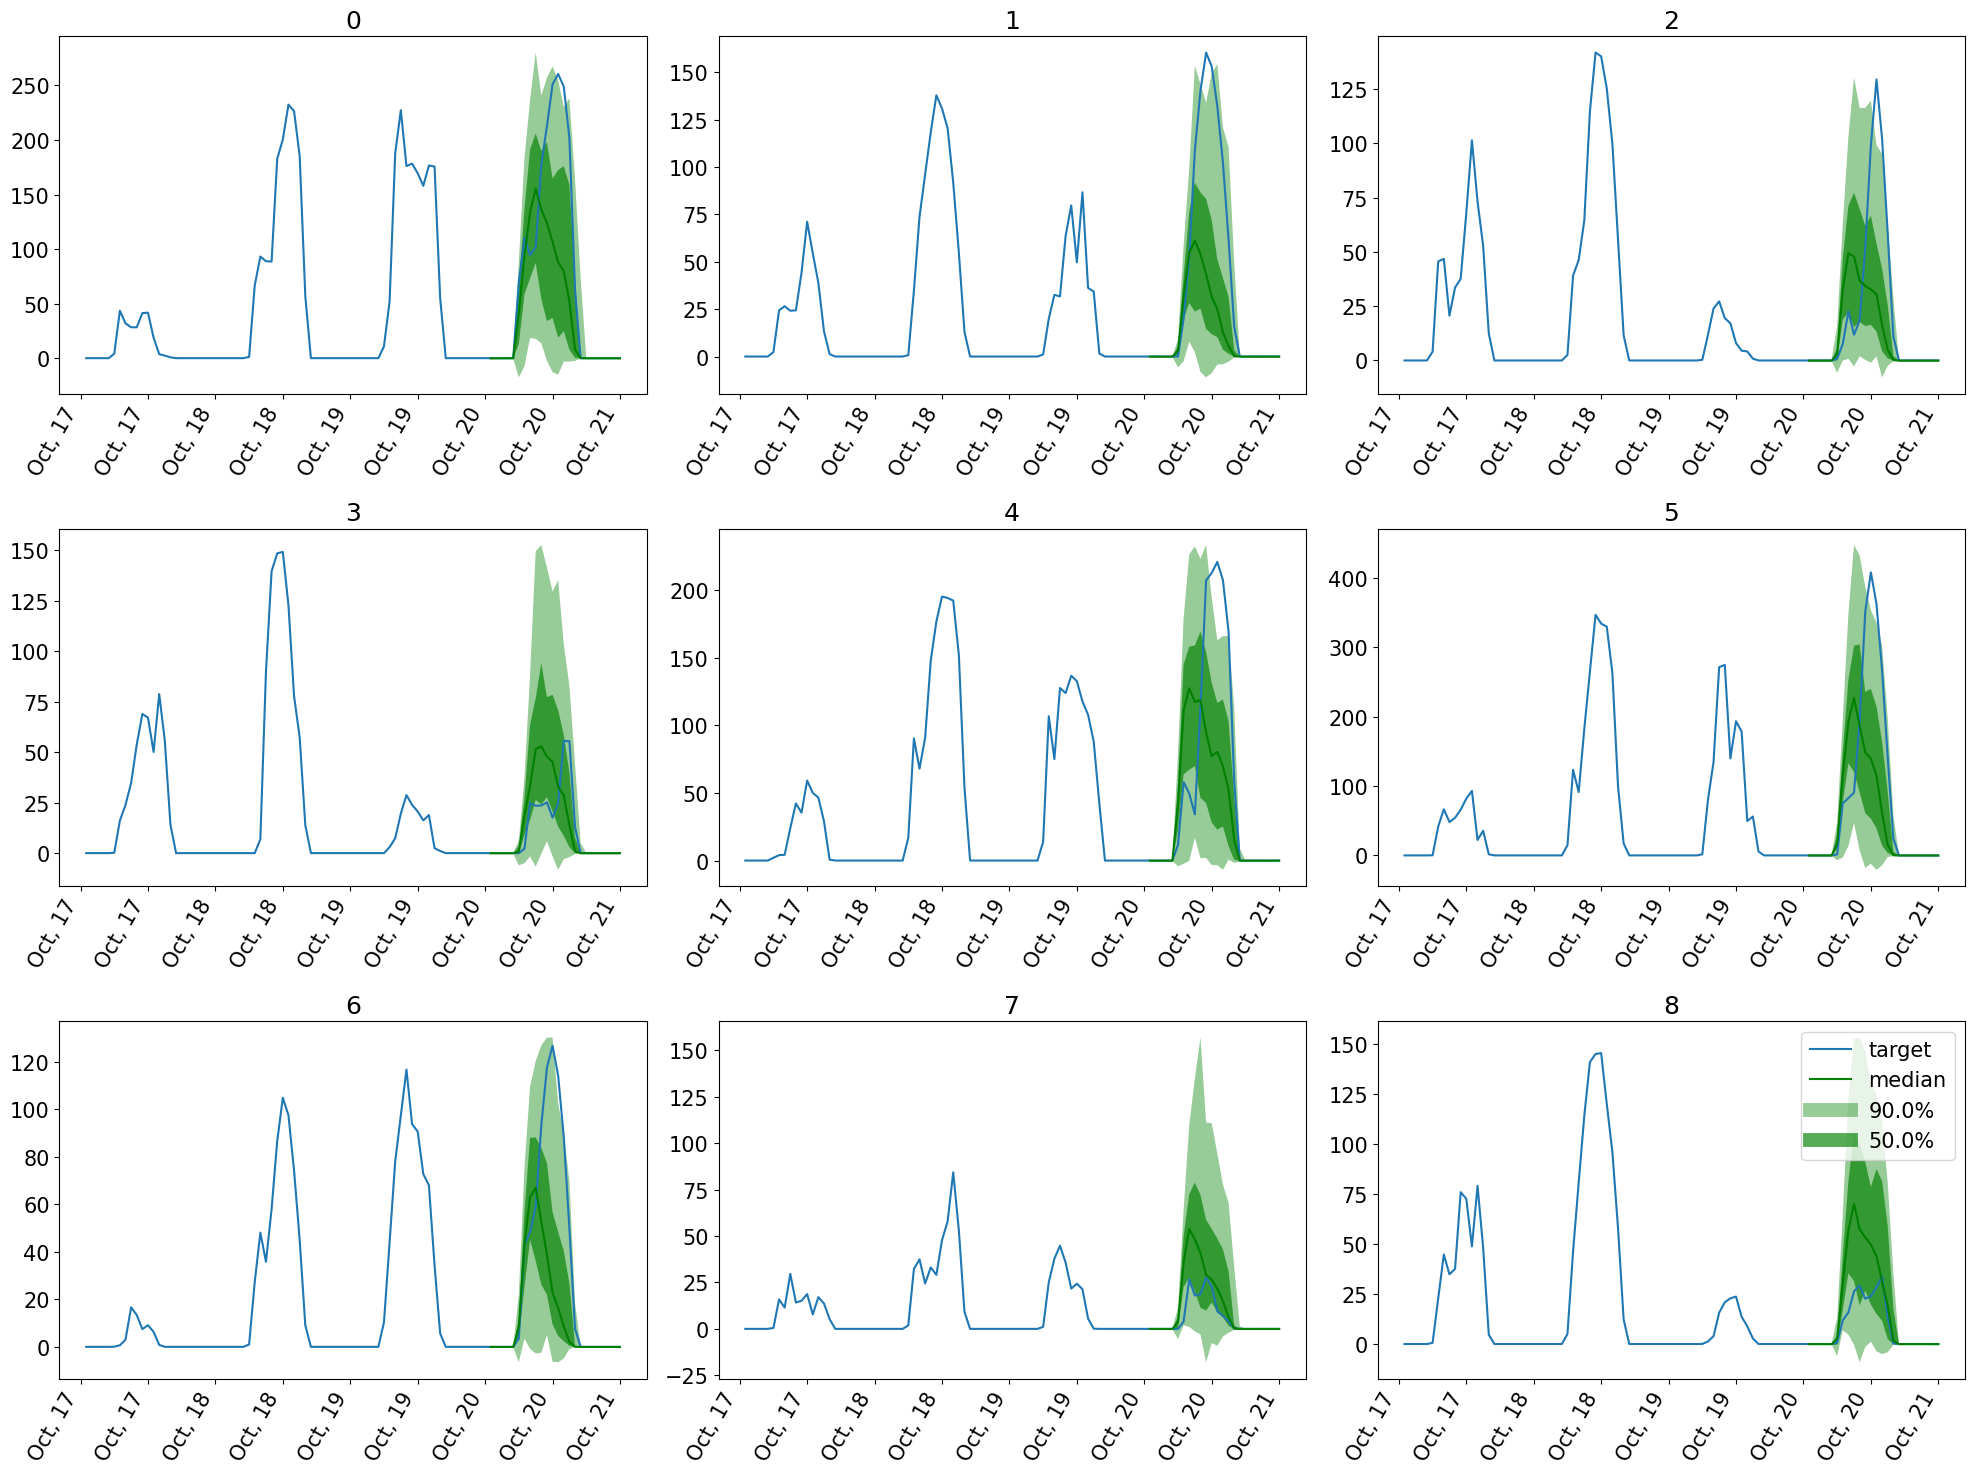

In [30]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * dataset.metadata.prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [18]:
metrics = pd.read_csv("lightning_logs/version_86/metrics.csv")

In [19]:
metrics

,train_perplexity,epoch,step,val_loss,train_loss
0,2.042362,0,49,NaN,NaN
1,2.050069,0,99,NaN,NaN
2,2.743227,0,149,NaN,NaN
3,2.440984,0,199,NaN,NaN
4,NaN,0,199,4.355846,NaN
...,...,...,...,...,...
295,80.659866,49,9899,NaN,NaN
296,82.568138,49,9949,NaN,NaN
297,81.211136,49,9999,NaN,NaN
298,NaN,49,9999,1.084462,NaN


Text(0, 0.5, 'perplexity')

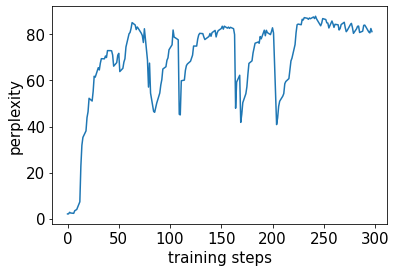

In [20]:
ax = metrics.train_perplexity.dropna().plot(kind="line")
ax.set_xlabel("training steps")
ax.set_ylabel("perplexity")

Text(0, 0.5, 'val neg. log likelihood')

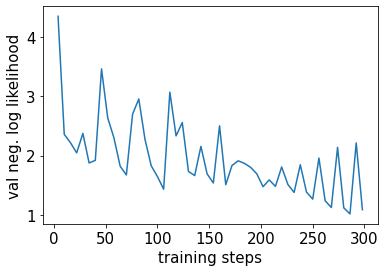

In [21]:
ax = metrics.val_loss.dropna().plot()
ax.set_xlabel("training steps")
ax.set_ylabel("val neg. log likelihood")

In [22]:
X = predictor.prediction_net.vq_vae.embed.cpu()

In [23]:
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X)

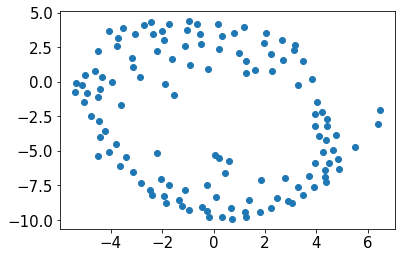

In [24]:
plt.scatter(X_embedded[:,0], X_embedded[:,1], alpha=1.0)